In [1]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import matplotlib.ticker as mticker

# Load SST data
fn = './sst.mnmean.nc'
data = xr.open_dataset(fn)
data = data.sel(time=slice('1997-09','2023-07'))
sst = data.sst
sst = sst.sel(lat=slice(32, -22))
sst = sst.sel(lon=slice(38, 122))

# Function to calculate mean values over specified months
def calculate_monthly_mean(data, months):
    data_selected = data.sel(time=np.in1d(data['time.month'], months))
    data_clm = data_selected.groupby('time.month').mean('time')
    return data_clm.mean('month')

# Calculate JJASON mean SST for Code 1
average_sst = calculate_monthly_mean(sst, [6, 7, 8, 9, 10, 11])

# Load wind data for Code 1
fn1 = './surface_winds_ERA5.nc'
ds = xr.open_dataset(fn1)
ds = ds.sel(time=slice('1997-09', '2023-07'))
ds = ds.sel(latitude=slice(30, -20))
ds = ds.sel(longitude=slice(40, 120))
ds = ds.rename({'latitude': 'lat', 'longitude': 'lon'}).isel(expver=0).drop_vars('expver')

u = ds.u10
v = ds.v10

# Calculate JJASON mean values for u and v
u_average = calculate_monthly_mean(u, [6, 7, 8, 9, 10, 11])
v_average = calculate_monthly_mean(v, [6, 7, 8, 9, 10, 11])

def plot_combined(ax, average_sst, ur, vr):
    contour = average_sst.plot.contourf(ax=ax, levels=25, extend='both', vmin=22, vmax=30, cmap='RdBu_r', 
                                        cbar_kwargs={'shrink': 0.5, 'aspect': 20, 'label': '(deg C)'})
    x, y = np.meshgrid(ur.lon, ur.lat)
    q = ax.quiver(x[::10, ::10], y[::10, ::10], ur[::10, ::10], vr[::10, ::10], color='k', alpha=0.7, headwidth=6, 
                  scale=20, scale_units='inches', headlength=5, width=0.002, transform=ccrs.PlateCarree())
    land = cfeature.NaturalEarthFeature(category='physical', name='land', scale='50m', facecolor=cfeature.COLORS['land'])
    ax.add_feature(land, edgecolor='black', facecolor='gray')
    ax.coastlines(resolution='10m', linewidth=1)
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=0, color='gray', alpha=0, linestyle='--')
    gl.xlabels_top = False
    gl.ylabels_right = False
    gl.xlocator = mticker.MultipleLocator(base=20)
    gl.ylocator = mticker.MultipleLocator(base=10)
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    ax.quiverkey(q, X=0.92, Y=1.02, U=5, label='5 m/s', labelpos='E')
    ax.set_title('a) Mean state - SST and low level Winds [JJASON]', loc='left')

# Calculate SST anomalies and DMI for Code 2
def anomcal(data, months):
    clm = data.groupby('time.month').mean('time')
    data = data.groupby('time.month') - clm
    return data.sel(time=np.in1d(data['time.month'], months))

sst_son = anomcal(sst, [9, 10, 11])

def detrend(sst, dim, deg=1):
    p = sst.polyfit(dim=dim, deg=deg)
    fit = xr.polyval(sst[dim], p.polyfit_coefficients)
    return sst - fit

def dmi(sst, lat1, lat2, lon1, lon2):
    sst = sst.sel(lat=slice(lat1, lat2), lon=slice(lon1, lon2))
    clm = sst.groupby('time.month').mean('time')
    an_sst = sst.groupby('time.month') - clm
    an_sst = an_sst.mean(('lat', 'lon'))
    return detrend(an_sst, dim='time')

wio = dmi(sst, 10, -10, 50, 70)
eio = dmi(sst, 0, -10, 90, 110)
obs_dmi = wio - eio

def iodcomp(index, data):
    std = index.sel(time=np.in1d(index['time.month'], [6, 7, 8, 9, 10, 11])).std()
    index = index.sel(time=np.in1d(index['time.month'], [9, 10, 11]))
    index = np.where(np.abs(index) < std, np.nan, index)
    nd = data.shape
    ds = np.empty(nd)
    for i in range(nd[0]):
        ds[i] = np.where(index[i] > 0, data[i], np.nan)
    ds = np.nanmean(ds, axis=0)
    return xr.DataArray(ds, dims=['lat', 'lon'], coords={'lat': data.lat, 'lon': data.lon})

sst_piod_compson = iodcomp(obs_dmi, sst_son)

C:\Users\thivi\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,
C:\Users\thivi\AppData\Local\Temp\ipykernel_14612\714626492.py:92: RuntimeWarning: Mean of empty slice
  ds = np.nanmean(ds, axis=0)


C:\Users\thivi\anaconda3\Lib\site-packages\cartopy\mpl\gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
C:\Users\thivi\anaconda3\Lib\site-packages\cartopy\mpl\gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '
C:\Users\thivi\anaconda3\Lib\site-packages\cartopy\mpl\gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
C:\Users\thivi\anaconda3\Lib\site-packages\cartopy\mpl\gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. P

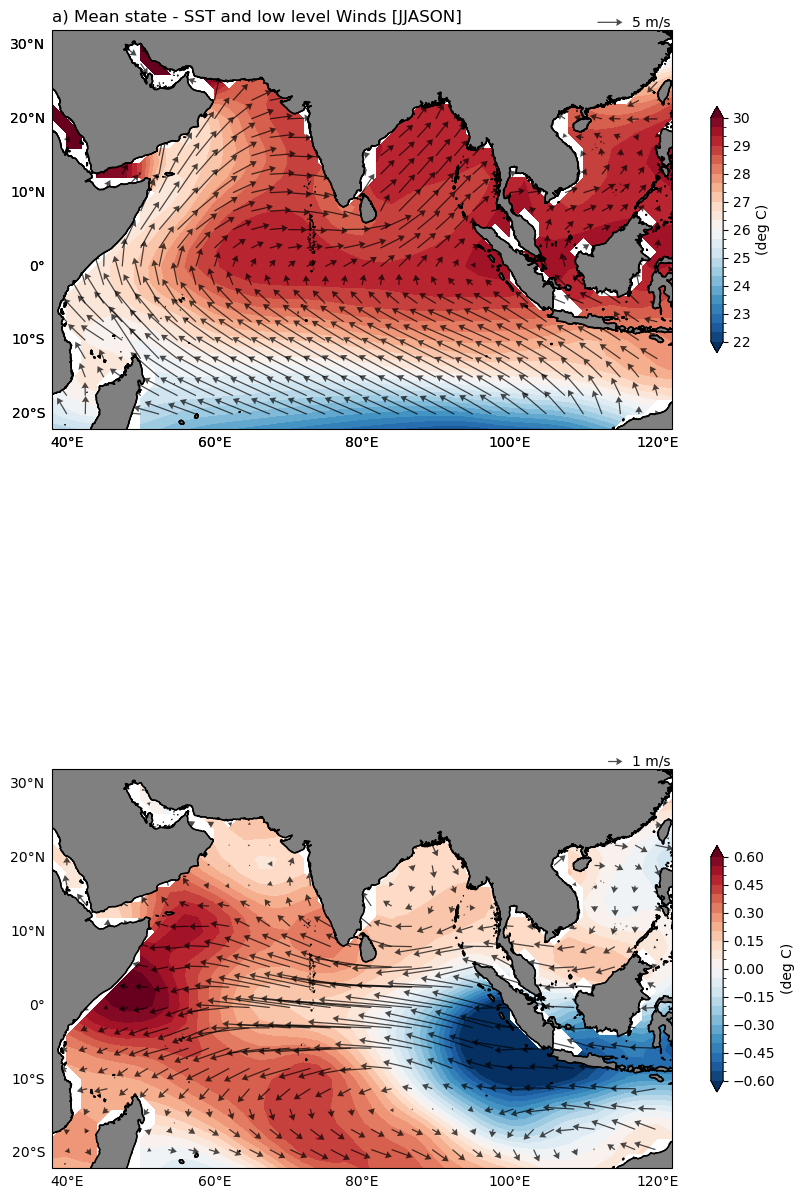

In [7]:
# Load wind data for Code 2
fn2 = './low_level_winds_850hPa.nc'
ds2 = xr.open_dataset(fn2)
ds2 = ds2.sel(time=slice('1997-09', '2023-07'))
ds2 = ds2.sel(latitude=slice(30, -21))
ds2 = ds2.sel(longitude=slice(40, 120))
ds2 = ds2.rename({'latitude': 'lat', 'longitude': 'lon'}).isel(expver=0).drop_vars('expver')

u2 = ds2.u
v2 = ds2.v

u_son = anomcal(u2, [9, 10, 11])
v_son = anomcal(v2, [9, 10, 11])

u_piod_compson = iodcomp(obs_dmi, u_son)
v_piod_compson = iodcomp(obs_dmi, v_son)

def uv_plot(ax, ur, vr):
    x, y = np.meshgrid(ur.lon, ur.lat)
    q = ax.quiver(x[::11, ::11], y[::11, ::11], ur[::11, ::11], vr[::11, ::11], color='k', alpha=0.7, headwidth=6, 
                  scale=7, scale_units='inches', headlength=5, width=0.002, transform=ccrs.PlateCarree())
    ax.quiverkey(q, X=0.92, Y=1.02, U=1, label='1 m/s', labelpos='E')

# Create a figure with 2 rows and 1 column of subplots
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(10, 16), subplot_kw={'projection': ccrs.PlateCarree()})

# Plot combined SST and wind data for subplot 1
plot_combined(axs[0], average_sst, u_average, v_average)

# Create contour plot for SST data and wind vectors for subplot 2
contour = sst_piod_compson.plot.contourf(ax=axs[1], levels=25, extend='both', vmin=-0.6, vmax=0.6, cmap='RdBu_r', 
                                         cbar_kwargs={'shrink': 0.5, 'aspect': 20, 'label': '(deg C)'})
uv_plot(axs[1], u_piod_compson, v_piod_compson)

# Add land boundaries and coastlines for both subplots
for ax in axs:
    land = cfeature.NaturalEarthFeature(category='physical', name='land', scale='50m', facecolor=cfeature.COLORS['land'])
    ax.add_feature(land, edgecolor='black', facecolor='gray')
    ax.coastlines(resolution='10m', linewidth=1)
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=0, color='gray', alpha=0, linestyle='--')
    gl.xlabels_top = False
    gl.ylabels_right = False
    gl.xlocator = mticker.MultipleLocator(base=20)
    gl.ylocator = mticker.MultipleLocator(base=10)
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER

# Adjust the space between the two subplots
plt.subplots_adjust(hspace=0.5)  # Decrease the value to reduce the space

plt.show()
